# Анастасия Куканова, A3200
## Задание 4. Random Forest

### Исходный код

In [65]:
% matplotlib inline

from collections import Counter
import math
import matplotlib.pyplot as plt
import numpy as np
from random import choice, shuffle
from sklearn import datasets, ensemble

#### Реализация метрик

In [9]:
class ProbabilityCounter(Counter):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def probabilities(self):
        total = sum(self.values())
        return dict(zip(self.keys(), map(lambda v: v / total, self.values())))

    def most_probable(self):
        return self.most_common(1)[0][0]


def gini(Y):
    if len(Y):
        probabilities = ProbabilityCounter(Y).probabilities()
        return 1 - sum(map(lambda k: probabilities[k] ** 2, probabilities))
    else:
        return -1


def entropy(Y):
    if len(Y):
        probabilities = ProbabilityCounter(Y).probabilities()
        return -sum(map(lambda k: probabilities[k] * math.log2(probabilities[k]), probabilities))
    else:
        return -1

#### Реализация CART

In [10]:
class Condition(object):
    def __init__(self, i, p):
        self.i = i
        self.p = p
        self.cond = lambda x: x[self.i] < self.p

    def __str__(self):
        return "x[{}] < {}".format(self.i, self.p)

    def __call__(self, *args):
        return self.cond(*args)


class DecisionTree(object):
    def __init__(self, metric="entropy", min_samples_split=2):
        if metric == "gini":
            self.metric = gini
        elif metric == "entropy":
            self.metric = entropy
        else:
            self.metric = metric
        self.min_samples_split = min_samples_split

    def fit(self, X, Y, features=None):
        self.conditions = self._form_conditions(X, features)
        self.head = self._Node(self, X, Y)

    def predict(self, x):
        return self.head.predict(x).most_probable()

    def predict_many(self, X):
        return list(map(self.predict, X))

    def predict_probabilities(self, x):
        return self.head.predict(x).probabilities()

    @staticmethod
    def _form_conditions(X, cols=None):
        if cols is None:
            cols = range(X.shape[1])
        conditions = []
        for i in cols:
            col = X[:, i]
            points = list(set(col))
            points.sort()
            conditions.extend(list(map(lambda p: Condition(i, p), points)))
        return conditions

    @staticmethod
    def _split_by_condition(X, Y, cond):
        X_pos = []
        X_neg = []
        Y_pos = []
        Y_neg = []
        for (x, y) in zip(X, Y):
            if cond(x):
                X_pos.append(x)
                Y_pos.append(y)
            else:
                X_neg.append(x)
                Y_neg.append(y)
        return (X_pos, Y_pos), (X_neg, Y_neg)

    def _calculate_gains(self, X, Y):
        m = self.metric(Y)
        gains = []
        for cond in self.conditions:
            (_, Y_pos), (_, Y_neg) = self._split_by_condition(X, Y, cond)
            gains.append(m - (len(Y_pos) * self.metric(Y_pos) + len(Y_neg) * self.metric(Y_neg)) / len(Y))
        return gains

    class _Node(object):
        def __init__(self, tree, X, Y):
            gains = tree._calculate_gains(X, Y)
            max_gain = max(gains)
            if math.isclose(max_gain, 0, abs_tol=1e-5) or len(X) < tree.min_samples_split:
                self.is_leaf = True
                self.result = ProbabilityCounter(Y)
            else:
                self.is_leaf = False
                self.condition = list(filter(lambda p: p[1] == max_gain, zip(tree.conditions, gains)))[0][0]
                pos, neg = tree._split_by_condition(X, Y, self.condition)
                self.positive = tree._Node(tree, *pos)
                self.negative = tree._Node(tree, *neg)

        def predict(self, x):
            if self.is_leaf:
                return self.result
            else:
                if self.condition(x):
                    return self.positive.predict(x)
                else:
                    return self.negative.predict(x)

#### Реализация Random Forest

In [11]:
class RandomForest(object):
    def __init__(self, metric="entropy", n_trees=10, m_features=None):
        self.n_trees = n_trees
        self.m_features = m_features
        self.trees = [DecisionTree(metric) for _ in range(n_trees)]

    def fit(self, X, Y):
        for tree in self.trees:
            rand_X = []
            rand_Y = []
            ind = list(range(len(X)))
            for _ in range(len(X)):
                i = choice(ind)
                (x, y) = (X[i], Y[i])
                rand_X.append(x)
                rand_Y.append(y)
            rand_X = np.array(rand_X)
            rand_Y = np.array(rand_Y)
            if self.m_features is None or self.m_features == X.shape[1]:
                cols = None
            else:
                indices = list(range(X.shape[1]))
                cols = set()
                for _ in range(self.m_features):
                    i = choice(indices)
                    cols.add(i)
                    indices.remove(i)
            tree.fit(rand_X, rand_Y, cols)

    def predict(self, x):
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(x))
        return ProbabilityCounter(predictions).most_probable()

    def predict_many(self, X):
        return list(map(self.predict, X))

#### CV

In [12]:
precision = lambda y_model, y_true: sum(list(map(lambda p: 1 if p[0] == p[1] else 0, zip(y_model, y_true)))) / len(y_model)

def k_fold(k, x, y, error_func, model_builder, *args, **kwargs):
    ind = list(range(len(x)))
    shuffle(ind)
    cv = 0
    q = int(len(x) / k)
    r = len(x) % k
    nums = []
    for i in range(r):
        nums.append(i * (q + 1))
    for i in range(r, k):
        nums.append(i * q + r)
    nums.append(len(x))
    for i in range(k):
        outer_x = []
        new_x = []
        outer_y = []
        new_y = []
        for j in range(len(x)):
            if j in range(nums[i], nums[i + 1]):
                outer_x.append(x[ind[j]])
                outer_y.append(y[ind[j]])
            else:
                new_x.append(x[ind[j]])
                new_y.append(y[ind[j]])
        new_x = np.array(new_x)
        new_y = np.array(new_y)
        outer_x = np.array(outer_x)
        outer_y = np.array(outer_y)
        model = model_builder(new_x, new_y, *args, **kwargs)
        cv += error_func(model(outer_x), outer_y)
    cv /= k
    return cv

#### Интерфейсы для классификаторов

In [13]:
def build_decision_tree(X, Y, metric="entropy", min_sample_split=2):
    tree = DecisionTree(metric, min_sample_split)
    tree.fit(X, Y)
    return tree.predict_many


def build_random_forest(X, Y, metric="entropy", n_trees=10, m_features=None):
    forest = RandomForest(metric, n_trees, m_features)
    forest.fit(X, Y)
    return forest.predict_many


def build_sklearn_rf(X, Y, metric="entropy", n_trees=10, m_features=None):
    if m_features is None:
        m_features = X.shape[1]
    forest = ensemble.RandomForestClassifier(n_trees, metric, max_features=m_features)
    forest.fit(X, Y)
    return forest.predict

#### Загрузка датасета

In [15]:
iris = datasets.load_iris()
__X__ = iris.data
__Y__ = iris.target

### CV и grid search для CART

В качестве алгоритма кросс-валидации используем k-fold с k = 10.
Проведем grid search для параметра `min_sample_split` (минимально необходимое число точек датасета в узле для его деления) just for fun (в задании не требуется, но почему бы и нет).

In [12]:
gs = []
for split in range(2, 16):
    a = np.array([k_fold(10, __X__, __Y__, precision, build_decision_tree, metric="entropy", min_sample_split=split)
                  for _ in range(50)]).mean()
    print(split, ":", a)
    gs.append((a, split))
print()
max_precision = max(map(lambda x: x[0], gs))
print("Maximum precision:", max_precision)
best_params = list(filter(lambda x: x[0] == max_precision, gs))
for param in best_params:
    print("min_sample_split =", param[1])

2 : 0.935333333333
3 : 0.9256
4 : 0.924666666667
5 : 0.926933333333
6 : 0.9368
7 : 0.934533333333
8 : 0.936933333333
9 : 0.9368
10 : 0.9388
11 : 0.937866666667
12 : 0.937733333333
13 : 0.936666666667
14 : 0.936133333333
15 : 0.936133333333

Maximum precision: 0.9388
min_sample_split = 10


В целом результат неплохой. Лучший результат достигается при значении `min_sample_split` = 10, но улучшение незначительное.

### CV и grid search для Random Forest

В качестве алгоритма кросс-валидации так же используется k-fold c k = 10.

In [23]:
cv_data1 = []
for n in range(10, 51, 10):
    for m in range(3, 5):
        a = np.array([k_fold(10, __X__, __Y__, precision, build_random_forest, metric="entropy", m_features=m, n_trees=n)
                      for _ in range(10)]).mean()
        print(n, "trees,", m, "features :", a)
        cv_data1.append((a, (n, m)))

10 trees, 3 features : 0.938666666667
10 trees, 4 features : 0.941333333333
20 trees, 3 features : 0.939333333333
20 trees, 4 features : 0.944666666667
30 trees, 3 features : 0.947333333333
30 trees, 4 features : 0.948
40 trees, 3 features : 0.940666666667
40 trees, 4 features : 0.95
50 trees, 3 features : 0.943333333333
50 trees, 4 features : 0.942


Добавим пару промежуточных точек в диапазоне с лучшими значениями метрики:

In [24]:
cv_data2 = []
for n in [35, 45]:
    for m in [3, 4]:
        a = np.array([k_fold(10, __X__, __Y__, precision, build_random_forest, metric="entropy", m_features=m, n_trees=n)
                      for _ in range(10)]).mean()
        print(n, "trees,", m, "features :", a)
        cv_data2.append((a, (n, m)))

35 trees, 3 features : 0.944666666667
35 trees, 4 features : 0.952666666667
45 trees, 3 features : 0.946
45 trees, 4 features : 0.95


Следующий эксперимент проводится для наблюдения зависимости точности от количества используемых фич:

In [25]:
cv_data3 = []
for n in [30, 35, 40, 45]:
    for m in [1, 2]:
        a = np.array([k_fold(10, __X__, __Y__, precision, build_random_forest, metric="entropy", m_features=m, n_trees=n)
                      for _ in range(10)]).mean()
        print(n, "trees,", m, "features :", a)
        cv_data.append((a, (n, m)))
        

30 trees, 1 features : 0.916666666667
30 trees, 2 features : 0.940666666667
35 trees, 1 features : 0.912666666667
35 trees, 2 features : 0.948
40 trees, 1 features : 0.914
40 trees, 2 features : 0.940666666667
45 trees, 1 features : 0.914
45 trees, 2 features : 0.943333333333


#### Исследование работоспособности с экстремальными параметрами

In [26]:
cv_data4 = []
for n in [150]:
    for m in [1, 4]:
        a = np.array([k_fold(10, __X__, __Y__, precision, build_random_forest, metric="entropy", m_features=m, n_trees=n)
                      for _ in range(5)]).mean()
        print(n, "trees,", m, "features :", a)
        cv_data4.append((a, (n, m)))

150 trees, 1 features : 0.917333333333
150 trees, 4 features : 0.946666666667


Тенденция, в общем-то, сохранилась. На одной фиче обучается плохо, на четырех хорошо. Следует отметить, что наблюдается насыщение точности: при увеличении количества деревьев в 3 раза она не возросла.

### Точность в зависимости от числа деревьев и числа признаков

Здесь мой ноутбук решил сходить в незапланированный ребут, поэтому результаты предыдущих экспериментов были сохранены из этого блокнота в txt-файл и подгружаются оттуда:

In [40]:
cv_data_file = open("cv_data.txt", "r")
cv_data = []

for line in cv_data_file:
    splited = line.replace('\n','').split(' ')
    n = int(splited[0])
    m = int(splited[2])
    a = float(splited[5])
    cv_data.append((a, (n, m)))

cv_data_file.close()

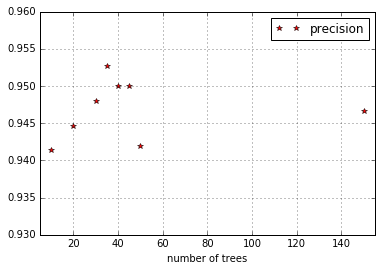

In [66]:
m_4 = list(filter(lambda t: t[1][1] == 4, cv_data))
ns = []
pres = []
for t in m_4:
    ns.append(t[1][0])
    pres.append(t[0])
    

plt.plot(ns, pres, "*r", label="precision")
axes = plt.gca()
axes.set_xlabel("number of trees")
axes.set_xlim([5,155])
axes.set_ylim([0.93,0.96])
plt.grid()
plt.legend()
plt.show()

По моим соображениям, должен наблюдаться линейный тренд с последующим насыщением (переходом в константу). В принципе, он наблюдается, если списать погрешности на то, что средний результат кросс-валидации берется всего за 10 экспериментов из-за большого времени работы.

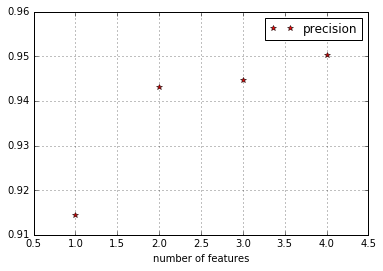

In [67]:
filt = list(filter(lambda t: t[1][0] in [30, 35, 40, 45], cv_data))

ms = [1, 2, 3, 4]
pres = []
for m in ms:
    a = sum(map(lambda t: t[0], filter(lambda t: t[1][1] == m, filt)))/4
    pres.append(a)


plt.plot(ms, pres, "*r", label="precision")
axes = plt.gca()
axes.set_xlabel("number of features")
axes.set_xlim([0.5,4.5])
axes.set_ylim([0.91,0.96])
plt.grid()
plt.legend()
plt.show()

Наблюдается рост точности с увеличением числа признаков. Мои соображения на этот счет: фактически, алгоритм CART имеет встроенный feature selection - за счет выбора наилучшего разбиения в каждом узле получается, что малоинформативные признаки либо не используются вообще, либо используются в нижней части дерева, в области, где начинается overfit. Выбор же признаков случайным образом способен исключить наиболее информативные из рассмотрения. В силу того, что общее число признаков в датасете небольшое (4), это случается достаточно часто. Отсюда и получается, что модель, обученная на 4 признаках, всегда проявляет себя лучше.

### Сравнение с реализацией в scikit-learn и kNN

In [69]:
print("sklearn:")
cv_data_sk = []
for n in [30, 35, 40, 45]:
    for m in [4]:
        a = np.array([k_fold(10, __X__, __Y__, precision, build_sklearn_rf, metric="entropy", m_features=m, n_trees=n)
                      for _ in range(100)]).mean()
        print(n, "trees,", m, "features :", a)
        cv_data_sk.append((a, (n, m)))
        

sklearn:
30 trees, 4 features : 0.951133333333
35 trees, 4 features : 0.954466666667
40 trees, 4 features : 0.953533333333
45 trees, 4 features : 0.952933333333


Точность результатов реализации в sklearn несколько выше, но в целом сравнима.

Лучший результат kNN составил при аналогичном методе кросс-валидации составил 0.9666666666666668, что более чем на 0.01 выше.

### Соображения на тему времени работы алгоритма.

Пусть $p$ - количество точек в датасете, $m$ - количество используемых признаков.

Тогда для каждого дерева строится $O(mp)$ условий. Тогда выбор лучшего условия для разбиения в узле имеет сложность $O(mp^2)$, т.к. нужно проверить каждое условие на всём датасете.

Предположим, в нерегуляризованном дереве получается порядка $O(log(mp))$ узлов (не могу строго обосновать, но есть ощущение, что это хорошая оценка для среднего случая). Тогда сложность обучения одного дерева составляет $O(mp^2log(mp))$.

Пусть $n$ - число деревьев в RF. Тогда сложность обучения модели - $O(nmp^2log(mp))$.

Наконец, пусть $k$ - параметр k-fold, используемого для оценки моделей в grid search. 

Тогда $O(knmp^2log(mp))$ - сложность k-fold для одной модели (одного набора параметров $(m, n)$.

Очевидно, сложность высокая. Вообще, в силу того, что деревья никак не регуляризуются, время работы выходит большим, особенно реализация на Python.

(Что интересно, scikit-learn позволяет строить леса регуляризованных деревьев, хотя на лекции было сказано, что для Random Forest обрезание ветвей не проводится).